In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.analysis import circular_stats
import os 
seed = 2023

In [2]:
def moving_average(data:np.ndarray,win:int,step:int=1)-> np.ndarray:
    d_shape=data.shape
    count = 0
    if len(d_shape) == 3:
        d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
        for i_step in np.arange(0,d_shape[2]-win,step):
            d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
            count +=1
    if len(d_shape) == 2:
        d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
        for i_step in np.arange(0,d_shape[1]-win,step):
            d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
            count +=1
    if len(d_shape) == 1:
        d_avg = np.zeros((int(np.floor(d_shape[0]/step))))
        for i_step in np.arange(0,d_shape[0]-win,step):
            d_avg[count] = np.mean(data[i_step:i_step+win],axis=0)
            count +=1
    return d_avg

In [3]:
def get_task_variables(data:SpikeData,bhv:BhvData,in_out:str='in'):
    # Select trials (correct and DMTS task) and create task frame
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]

    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=bhv.condition[trial_idx],
        test_stimuli=bhv.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    task = task[task['in_out']==in_out]
    return task, trial_idx

In [4]:
def get_trials_by_sample(task,feature,trial_idx,bhv,data):
    sample_trials = {"o1":np.array([]),"o5":np.array([]),"c1":np.array([]),"c5":np.array([])}
    
    for key_sample in sample_trials.keys():
        sample_trials[key_sample]=np.unique(task.loc[task['sample'].str.contains(key_sample, case=False)]['trial_idx'].values)

    test_stimuli = bhv.test_stimuli[trial_idx][sample_trials[feature]]
    code_numbers = data.code_numbers[trial_idx][sample_trials[feature]]
    code_samples = data.code_samples[trial_idx][sample_trials[feature]]
    sp_samples = data.sp_samples[trial_idx][sample_trials[feature]]
    return test_stimuli,code_numbers,code_samples,sp_samples,sample_trials

In [5]:
def delete_match(test_stimuli,code):
    code = (code-1).astype(int)
    tests_shape=test_stimuli.shape
    test_stimuli = np.concatenate([test_stimuli,np.ones((tests_shape[0],1))],axis=1)
    test_stimuli[np.arange(tests_shape[0]),code] =  np.nan
    test_stimuli = test_stimuli[:,:tests_shape[1]]
    return test_stimuli.astype(str)

In [6]:
def get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient,stim_num):
    all_sp_tests=[]
    st = 0
    end =1
    if color_orient == 1:
        st = 1
        end =2
    for i_num,i_stim in enumerate(stim_num):
        i_trial, i_test = np.where(np.char.find(test_stimuli_samp,i_stim,start=st, end=end)==color_orient)
        tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
        sp_stim = sp_samples_samp[i_trial]
        sp_tests = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]
        if np.isnan(np.sum(sp_tests)):
            raise ValueError('nan values')
        all_sp_tests.append(sp_tests)
    return all_sp_tests

### Compute

In [7]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_sp_lip.txt", "r")
lines_sp = file1.readlines()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

### plots samples

In [8]:
orient = 0 
color = 1
n_iterations = 1000
win=100
step=1
samp_orient = (["o1_c1","o5_c1"],["o1_c5","o5_c5"])
samp_color = (["o1_c1","o1_c5"],["o5_c1","o5_c5"])

o_c = [color,color]
color_orient = color


In [9]:
paths_bhv[5:]

['/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-02_11-01-23_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-05_10-51-52_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-06_11-12-04_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-13_11-11-42_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-14_10-50-49_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-16_10-30-59_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-01-18_10-22-38_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-01-20_11-00-24_Riesling_e1_r1_bhv.h5',
 '/envau

In [10]:
# Neurons I checked
# path 0:  2022-11-22_10-59-03 i_neuron:1 -> no selectivity
# path 0:  2022-11-22_10-59-03 i_neuron:3 -> selective (not a lot) to o1
# path 2:  2022-11-30_10-42-03 i_neuron:2 -> a little bit of shift in orientation (but selectivity is not significant)
# path 3:  2022-12-01_10-23-18 i_neuron:0 -> no selectivity
# path 3:  2022-12-01_10-23-18 i_neuron:1 -> no selectivity
# path 3:  2022-12-01_10-23-18 i_neuron:3 -> no selectivity
# path 3:  2022-12-01_10-23-18 i_neuron:4 -> no selectivity
# path 4:  2022-12-01_12-01-59 i_neuron:5 -> no enough trials
# path 5:  2022-12-02_11-01-23 i_neuron:0 -> no selectivity
# path 5:  2022-12-02_11-01-23 i_neuron:4 -> shift in color (but no selectivity) -----
# path 5:  2022-12-02_11-01-23 i_neuron:11-> no selectivity
# path 6:  2022-12-05_10-51-52 i_neuron:6 -> no selectivity
# path 10: 2022-12-16_10-30-59 i_neuron:4 -> no selectivity
# path 17: 2023-02-24_10-43-44 i_neuron:0 -> not significant
# path 16: 2023-02-09_10-42-54 i_neuron:2 -> stroger activity for o5 than o1 when looking for o1
# path 27: 2023-03-17_10-11-51 i_neuron:2 -> no selectivity
# path 28: 2023-03-20_10-39-08 i_neuron:10 -> selective to c1 o5, no shift

In [11]:
# definir dataframe y agregar neurona y p value para cada orientacion
# selectivity_info: Dict[str, list] = defaultdict(list)

n_bhv=paths_bhv[16]
n_sp = paths_sp[16]
print(n_sp)
s_path = os.path.normpath(n_sp).split(os.sep)
date = s_path[-1][:19]
data = SpikeData.from_python_hdf5(n_sp)
bhv = BhvData.from_python_hdf5(n_bhv)

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-02-09_10-42-54_Riesling_lip_e1_r1_sp.h5


In [12]:
data.clustersgroup

array(['good', 'good', 'good', 'mua'], dtype='<U4')

In [13]:
i_neuron = 2

In [14]:
# correct and incorrect trials
trial_idx = np.where(data.block == 1)[0]

if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond=data.neuron_cond
task = def_task.create_task_frame(
    condition=bhv.condition[trial_idx],
    test_stimuli=bhv.test_stimuli[trial_idx],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond = neuron_cond,
)
task = task[task['in_out']=='in']


        i_neuron
sample          
o0_c0         36
o1_c1        127
o1_c5        108
o5_c1         96
o5_c5        105


current,o0_c0,o1_c1,o1_c5,o5_c1,o5_c5
previous,,,,,
o0_c0,0.055556,0.062992,0.111111,0.072917,0.066667
o1_c1,0.250000,0.196850,0.351852,0.250000,0.295238
o1_c5,0.277778,0.283465,0.120370,0.250000,0.238095
o5_c1,0.277778,0.220472,0.175926,0.166667,0.209524
o5_c5,0.138889,0.236220,0.240741,0.260417,0.180952


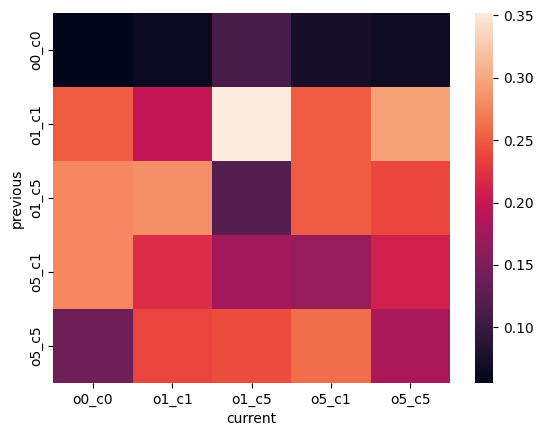

In [15]:
task_one_neuron = task[task['i_neuron']==0]
n_trials_sample = task_one_neuron[['i_neuron','sample']].groupby(['sample']).count()
print(n_trials_sample)
sorted_samples = task_one_neuron[['trial_idx','sample']].sort_values('trial_idx').reset_index(drop=True)['sample'].values
samples_dict = {'current':[],'previous':[]}
prev_sampl = sorted_samples[0]
for i_sample in sorted_samples[1:]:
    samples_dict['current'].append(i_sample)
    samples_dict['previous'].append(prev_sampl)
    prev_sampl = i_sample
samples_dict = pd.DataFrame(samples_dict)
curr_prev_sample = samples_dict.reset_index().groupby(['current','previous']).count().reset_index()
df = curr_prev_sample.pivot(index="previous", columns="current", values="index")
df['o0_c0'] = df['o0_c0']/n_trials_sample.loc['o0_c0'].values[0]
df['o1_c1'] = df['o1_c1']/n_trials_sample.loc['o1_c1'].values[0]
df['o1_c5'] = df['o1_c5']/n_trials_sample.loc['o1_c5'].values[0]
df['o5_c1'] = df['o5_c1']/n_trials_sample.loc['o5_c1'].values[0]
df['o5_c5'] = df['o5_c5']/n_trials_sample.loc['o5_c5'].values[0]
sns.heatmap(df)
df

In [16]:
all_task, all_trial_idx = get_task_variables(data,bhv,in_out='in')

In [17]:
all_task.head()

,i_neuron,trial_idx,sample,in_out,n_test_stimuli,code
0,0,3,o1_c1,in,2,2
1,0,9,o1_c1,in,2,2
2,0,11,o1_c1,in,2,2
3,0,18,o1_c1,in,2,2
4,0,46,o1_c1,in,2,2


        i_neuron
sample          
o0_c0         35
o1_c1         44
o1_c5         34
o5_c1         36
o5_c5         41


current,o0_c0,o1_c1,o1_c5,o5_c1,o5_c5
previous,,,,,
o0_c0,0.171429,0.136364,0.235294,0.138889,0.243902
o1_c1,0.142857,0.295455,0.352941,0.194444,0.146341
o1_c5,0.285714,0.136364,0.176471,0.250000,0.073171
o5_c1,0.257143,0.227273,0.029412,0.138889,0.268293
o5_c5,0.142857,0.204545,0.205882,0.277778,0.243902


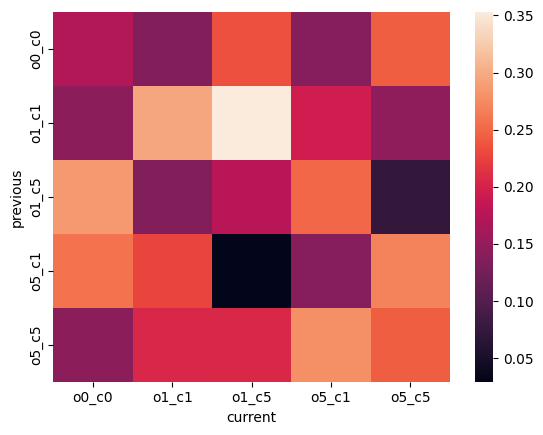

In [18]:
task_one_neuron = all_task[all_task['i_neuron']==0]
n_trials_sample = task_one_neuron[['i_neuron','sample']].groupby(['sample']).count()
print(n_trials_sample)
sorted_samples = task_one_neuron[['trial_idx','sample']].sort_values('trial_idx').reset_index(drop=True)['sample'].values
samples_dict = {'current':[],'previous':[]}
prev_sampl = sorted_samples[0]
for i_sample in sorted_samples[1:]:
    samples_dict['current'].append(i_sample)
    samples_dict['previous'].append(prev_sampl)
    prev_sampl = i_sample
samples_dict = pd.DataFrame(samples_dict)
curr_prev_sample = samples_dict.reset_index().groupby(['current','previous']).count().reset_index()
df = curr_prev_sample.pivot(index="previous", columns="current", values="index")
df['o0_c0'] = df['o0_c0']/n_trials_sample.loc['o0_c0'].values[0]
df['o1_c1'] = df['o1_c1']/n_trials_sample.loc['o1_c1'].values[0]
df['o1_c5'] = df['o1_c5']/n_trials_sample.loc['o1_c5'].values[0]
df['o5_c1'] = df['o5_c1']/n_trials_sample.loc['o5_c1'].values[0]
df['o5_c5'] = df['o5_c5']/n_trials_sample.loc['o5_c5'].values[0]
sns.heatmap(df)
df

In [19]:
print(df['o1_c1'].loc['o1_c1']+df['o1_c1'].loc['o1_c5'])
print(df['o1_c1'].loc['o5_c1']+df['o1_c1'].loc['o5_c5'])

0.4318181818181818
0.4318181818181818


In [20]:
print(df['o1_c5'].loc['o1_c1']+df['o1_c1'].loc['o1_c5'])
print(df['o1_c5'].loc['o5_c1']+df['o1_c1'].loc['o5_c5'])

0.4893048128342246
0.23395721925133692


In [21]:
task_tr = np.unique(all_task['trial_idx'].values)
trial_idx = task_tr[np.nansum(data.sp_samples[all_trial_idx[task_tr],i_neuron],axis=1)>0]
task = all_task[np.in1d(all_task['trial_idx'] , trial_idx)]
task=task[task['i_neuron']==i_neuron]

test_stimuli = bhv.test_stimuli[all_trial_idx]
code_numbers = data.code_numbers[all_trial_idx]
code_samples = data.code_samples[all_trial_idx]
sp_samples = data.sp_samples[all_trial_idx,i_neuron]

/tmp/ipykernel_100963/374276101.py:3: RuntimeWarning: invalid value encountered in cast
  test_stimuli_samp = test_stimuli_samp.astype(str)


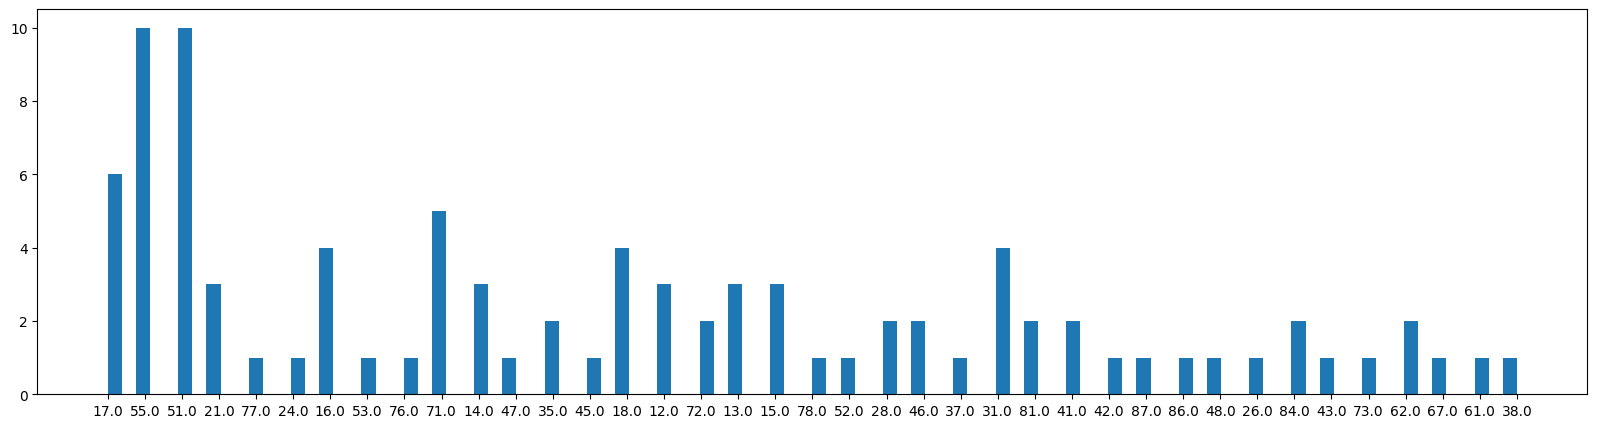

In [97]:
task_sample = task_one_neuron[task_one_neuron['sample']=='o1_c1']
test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
test_stimuli_samp = test_stimuli_samp.astype(str)
concat = np.concatenate(test_stimuli_samp)
concat = concat[np.where(np.logical_or(concat == 'nan',concat=='11.0'),False,True)]
fif,ax = plt.subplots(figsize=(20,5))
c=ax.hist(concat,bins=100)

<AxesSubplot: >

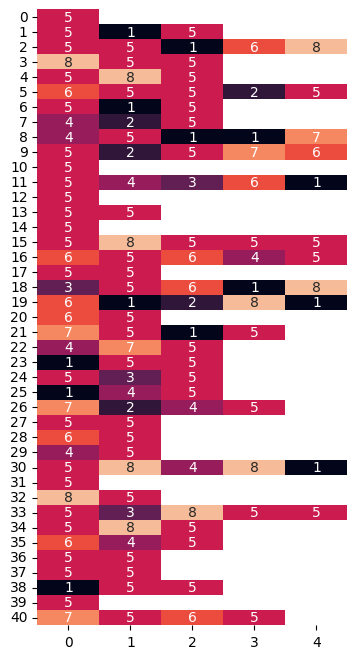

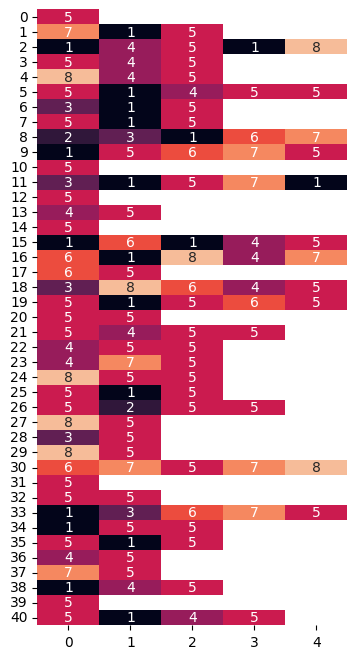

In [24]:
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'1',start=0, end=1)==orient,'o1','nan')
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'2',start=0, end=1)==orient,'o2',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'3',start=0, end=1)==orient,'o3',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'4',start=0, end=1)==orient,'o4',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'5',start=0, end=1)==orient,'o5',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'6',start=0, end=1)==orient,'o6',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'7',start=0, end=1)==orient,'o7',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'8',start=0, end=1)==orient,'o8',test_stimuli_o1)
mask = np.where(test_stimuli_o1=='nan',True,False)
test_stimuli_o = pd.DataFrame(test_stimuli_o1).replace(['o1','o2','o3','o4','o5','o6','o7','o8','nan'],[1,2,3,4,5,6,7,8,np.nan])
fx = plt.subplots(figsize=(4,8))
sns.heatmap(test_stimuli_o,mask=mask,vmax = 9,annot=True,cbar=False)

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'1',start=1, end=2)==color,'c1','nan')
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'2',start=1, end=2)==color,'c2',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'3',start=1, end=2)==color,'c3',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'4',start=1, end=2)==color,'c4',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'5',start=1, end=2)==color,'c5',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'6',start=1, end=2)==color,'c6',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'7',start=1, end=2)==color,'c7',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'8',start=1, end=2)==color,'c8',test_stimuli_c1)
mask = np.where(test_stimuli_c1=='nan',True,False)
test_stimuli_c = pd.DataFrame(test_stimuli_c1).replace(['c1','c2','c3','c4','c5','c6','c7','c8','nan'],[1,2,3,4,5,6,7,8,np.nan])
fx = plt.subplots(figsize=(4,8))
sns.heatmap(test_stimuli_c,mask=mask,vmax = 9,annot=True,cbar=False)

In [88]:
code_samples_samp = code_samples[task_sample['trial_idx']]
sp_samples_samp = sp_samples[task_sample['trial_idx']]

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'21')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o2_c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'31')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o3_c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'41')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o4_c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'51')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o5_c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'61')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o6_c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

In [77]:
code_samples_samp = code_samples[task_sample['trial_idx']]
sp_samples_samp = sp_samples[task_sample['trial_idx']]
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'15')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o1_c5 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

o1_cx 3
o3_c1 550
o4_c1 2
o5_c1 10
o6_c1 1


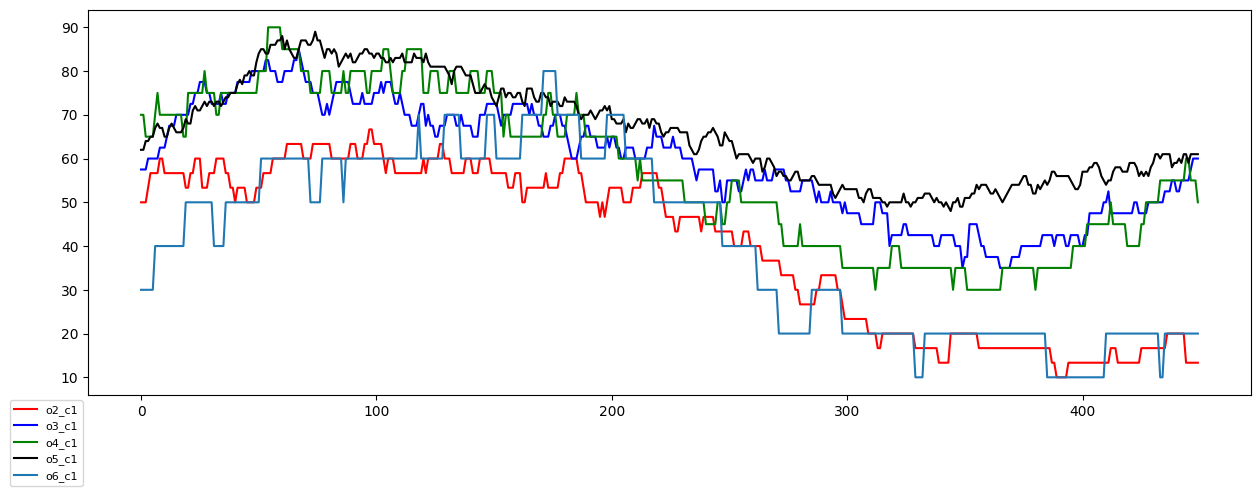

In [94]:
sp_tests_o2_c1_avg = sp_tests_o2_c1.mean(axis=0)
print('o1_cx %d'%sp_tests_o2_c1.shape[0])
sp_tests_o3_c1_avg = sp_tests_o3_c1.mean(axis=0)
print('o3_c1 %d'%sp_tests_o3_c1_avg.shape[0])
sp_tests_o4_c1_avg = sp_tests_o4_c1.mean(axis=0)
print('o4_c1 %d'%sp_tests_o4_c1.shape[0])
sp_tests_o5_c1_avg = sp_tests_o5_c1.mean(axis=0)
print('o5_c1 %d'%sp_tests_o5_c1.shape[0])
sp_tests_o6_c1_avg = sp_tests_o6_c1.mean(axis=0)
print('o6_c1 %d'%sp_tests_o6_c1.shape[0])
sp_tests_o2_c1_avg = moving_average(data=sp_tests_o2_c1_avg,win=win,step=1)[:450]*1000
sp_tests_o3_c1_avg = moving_average(data=sp_tests_o3_c1_avg,win=win,step=1)[:450]*1000
sp_tests_o4_c1_avg = moving_average(data=sp_tests_o4_c1_avg,win=win,step=1)[:450]*1000
sp_tests_o5_c1_avg = moving_average(data=sp_tests_o5_c1_avg,win=win,step=1)[:450]*1000
sp_tests_o6_c1_avg = moving_average(data=sp_tests_o6_c1_avg,win=win,step=1)[:450]*1000
fig,ax = plt.subplots(figsize = (15,5))
ax.plot(sp_tests_o2_c1_avg,label='o2_c1',color='r')
ax.plot(sp_tests_o3_c1_avg,label='o3_c1',color='b')
ax.plot(sp_tests_o4_c1_avg,label='o4_c1',color='g')
ax.plot(sp_tests_o5_c1_avg,label='o5_c1',color='k')
ax.plot(sp_tests_o6_c1_avg,label='o6_c1')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

In [95]:
code_samples_samp = code_samples[task_sample['trial_idx']]
sp_samples_samp = sp_samples[task_sample['trial_idx']]

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'12')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o2_c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'13')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o3_c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'14')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o4_c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'15')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o5_c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'16')==0,True,False)
i_trial, i_test = np.where(test_stimuli_c1)
tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
sp_stim = sp_samples_samp[i_trial]
sp_tests_o6_c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

o1_cx 3
o3_c1 550
o4_c1 3
o5_c1 3
o6_c1 4


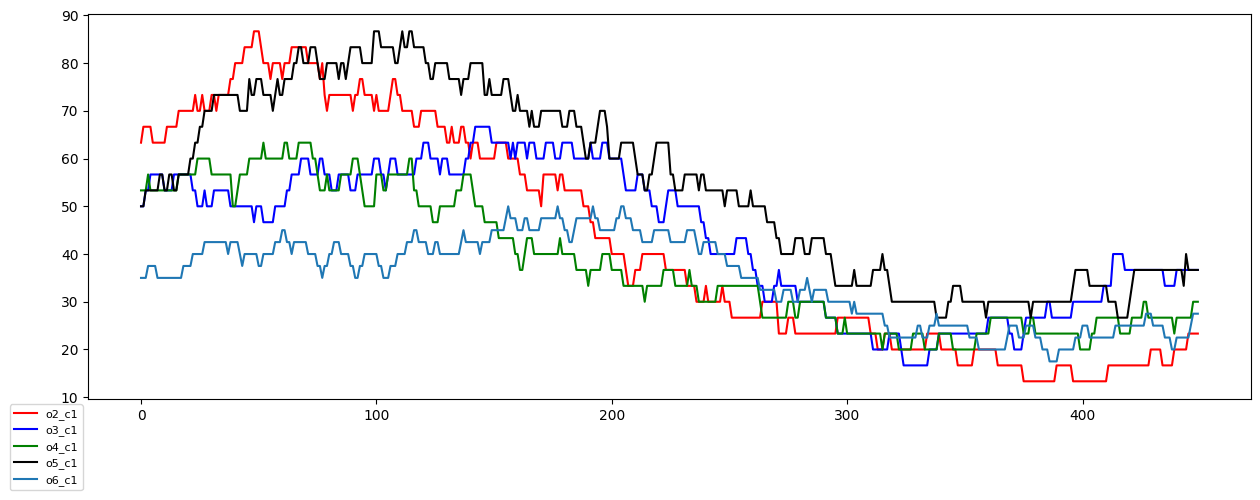

In [96]:
sp_tests_o2_c1_avg = sp_tests_o2_c1.mean(axis=0)
print('o1_cx %d'%sp_tests_o2_c1.shape[0])
sp_tests_o3_c1_avg = sp_tests_o3_c1.mean(axis=0)
print('o3_c1 %d'%sp_tests_o3_c1_avg.shape[0])
sp_tests_o4_c1_avg = sp_tests_o4_c1.mean(axis=0)
print('o4_c1 %d'%sp_tests_o4_c1.shape[0])
sp_tests_o5_c1_avg = sp_tests_o5_c1.mean(axis=0)
print('o5_c1 %d'%sp_tests_o5_c1.shape[0])
sp_tests_o6_c1_avg = sp_tests_o6_c1.mean(axis=0)
print('o6_c1 %d'%sp_tests_o6_c1.shape[0])
sp_tests_o2_c1_avg = moving_average(data=sp_tests_o2_c1_avg,win=win,step=1)[:450]*1000
sp_tests_o3_c1_avg = moving_average(data=sp_tests_o3_c1_avg,win=win,step=1)[:450]*1000
sp_tests_o4_c1_avg = moving_average(data=sp_tests_o4_c1_avg,win=win,step=1)[:450]*1000
sp_tests_o5_c1_avg = moving_average(data=sp_tests_o5_c1_avg,win=win,step=1)[:450]*1000
sp_tests_o6_c1_avg = moving_average(data=sp_tests_o6_c1_avg,win=win,step=1)[:450]*1000
fig,ax = plt.subplots(figsize = (15,5))
ax.plot(sp_tests_o2_c1_avg,label='o2_c1',color='r')
ax.plot(sp_tests_o3_c1_avg,label='o3_c1',color='b')
ax.plot(sp_tests_o4_c1_avg,label='o4_c1',color='g')
ax.plot(sp_tests_o5_c1_avg,label='o5_c1',color='k')
ax.plot(sp_tests_o6_c1_avg,label='o6_c1')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Plot response by samples

In [27]:
len_s_on=450
len_d=450
len_t = 450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_sample_on = np.zeros((4,len_s_on))
all_sp_delay = np.zeros((4,len_d))
all_sp_test1 = np.zeros((4,len_t))
all_sp_test2=np.zeros((4,len_t))
all_sp_test3=np.zeros((4,len_t))
all_sp_test4=np.zeros((4,len_t))
all_sp_test5=np.zeros((4,len_t))

for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    # sample on
    sp_sample_on = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,4].astype(int), axis=1)[:, :len_s_on+win]
    sp_sample_on = sp_sample_on.mean(axis=0)
    all_sp_sample_on[i] = moving_average(data=sp_sample_on,win=win,step=1)[:len_s_on]*1000
    # delay
    sp_delay = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,5].astype(int), axis=1)[:, :len_d+win]
    sp_delay = sp_delay.mean(axis=0)
    all_sp_delay[i] = moving_average(data=sp_delay,win=win,step=1)[:len_d]*1000
    # test 1
    idx = np.where(~np.isnan(code_samples_samp[:,6]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,6].astype(int), axis=1)[:, :len_t+win]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test1[i] = moving_average(data=sp_test,win=win,step=1)[:len_t]*1000
    # test 2
    idx = np.where(~np.isnan(code_samples_samp[:,8]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,8].astype(int), axis=1)[:, :len_t+win]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test2[i] = moving_average(data=sp_test,win=win,step=1)[:len_t]*1000
    # test 3
    idx = np.where(~np.isnan(code_samples_samp[:,10]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,10].astype(int), axis=1)[:, :len_t+win]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test3[i] = moving_average(data=sp_test,win=win,step=1)[:len_t]*1000
    # test 4
    idx = np.where(~np.isnan(code_samples_samp[:,12]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,12].astype(int), axis=1)[:, :len_t+win]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test4[i] = moving_average(data=sp_test,win=win,step=1)[:len_t]*1000
    # test 5
    idx = np.where(~np.isnan(code_samples_samp[:,14]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,14].astype(int), axis=1)[:, :len_t+win]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test5[i] = moving_average(data=sp_test,win=win,step=1)[:len_t]*1000


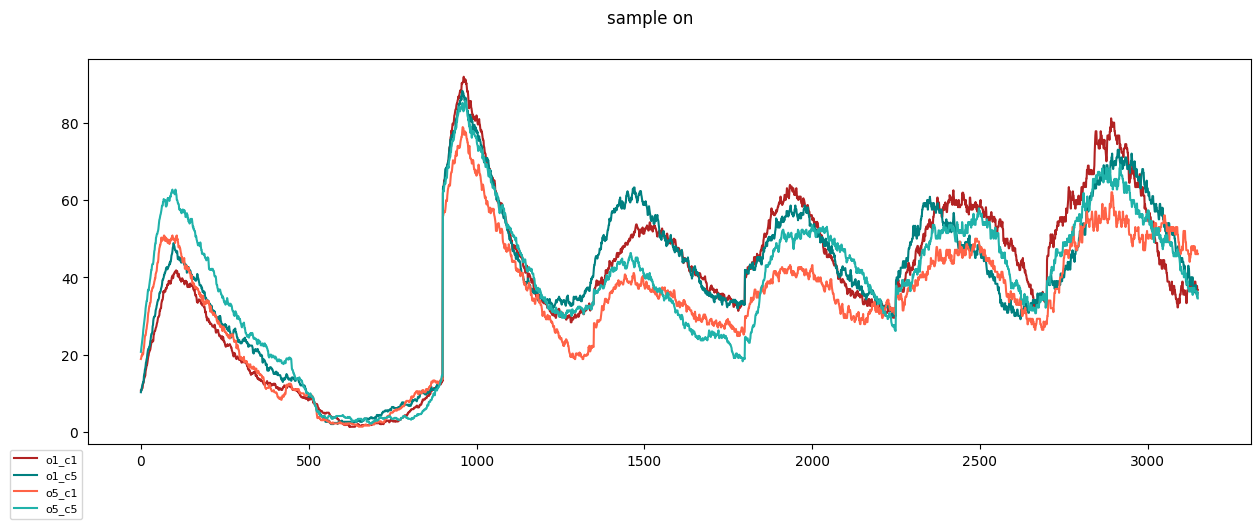

In [28]:
all_sp_epochs = np.concatenate([all_sp_sample_on,all_sp_delay,all_sp_test1,all_sp_test2,all_sp_test3,all_sp_test4,all_sp_test5],axis=1)
fig,ax = plt.subplots(figsize = (15,5))
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    ax.plot(all_sp_epochs[i],label=sample,color=task_constants.PALETTE_B1[sample])
fig.suptitle('sample on')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Plot response by feature (color 1, color 5, orientation 1, orientation 5)

In [29]:
win=100
all_sp_test1 = np.zeros((4,len_t+win))
all_sp_test2 = np.zeros((4,len_t+win))
all_sp_test3 = np.zeros((4,len_t+win))
all_sp_test4 = np.zeros((4,len_t+win))
all_sp_test5 = np.zeros((4,len_t+win))
all_sp_delay = np.zeros((4,len_t+win))
all_sp_sample_on = np.zeros((4,len_t+win))
# all_feature_t5_avg=[]
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    # sample on
    sp_sample_on = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,4].astype(int), axis=1)[:, :len_s_on+win]
    all_sp_sample_on[i] = sp_sample_on.mean(axis=0)
    # delay
    sp_delay = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,5].astype(int), axis=1)[:, :len_d+win]
    all_sp_delay[i] = sp_delay.mean(axis=0)
    # test 1
    idx = np.where(test_stimuli_samp[:,0]!='nan')[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,6].astype(int), axis=1)[:, :len_t+win]
    all_sp_test1[i] = sp_test.mean(axis=0)
    # test 2 
    idx = np.where(test_stimuli_samp[:,1]!='nan')[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,8].astype(int), axis=1)[:, :len_t+win]
    all_sp_test2[i] = sp_test.mean(axis=0)
    # test 3
    idx = np.where(test_stimuli_samp[:,2]!='nan')[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,10].astype(int), axis=1)[:, :len_t+win]    
    all_sp_test3[i] = sp_test.mean(axis=0)
    # test 4
    idx = np.where(test_stimuli_samp[:,3]!='nan')[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,12].astype(int), axis=1)[:, :len_t+win]
    all_sp_test4[i] = sp_test.mean(axis=0)
    # test 5
    idx = np.where(test_stimuli_samp[:,4]!='nan')[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,14].astype(int), axis=1)[:, :len_t+win]
    all_sp_test5[i] = sp_test.mean(axis=0)

all_sp_epochs_feture = [all_sp_sample_on,all_sp_delay,all_sp_test1,all_sp_test2,all_sp_test3,all_sp_test4,all_sp_test5]

/tmp/ipykernel_100963/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


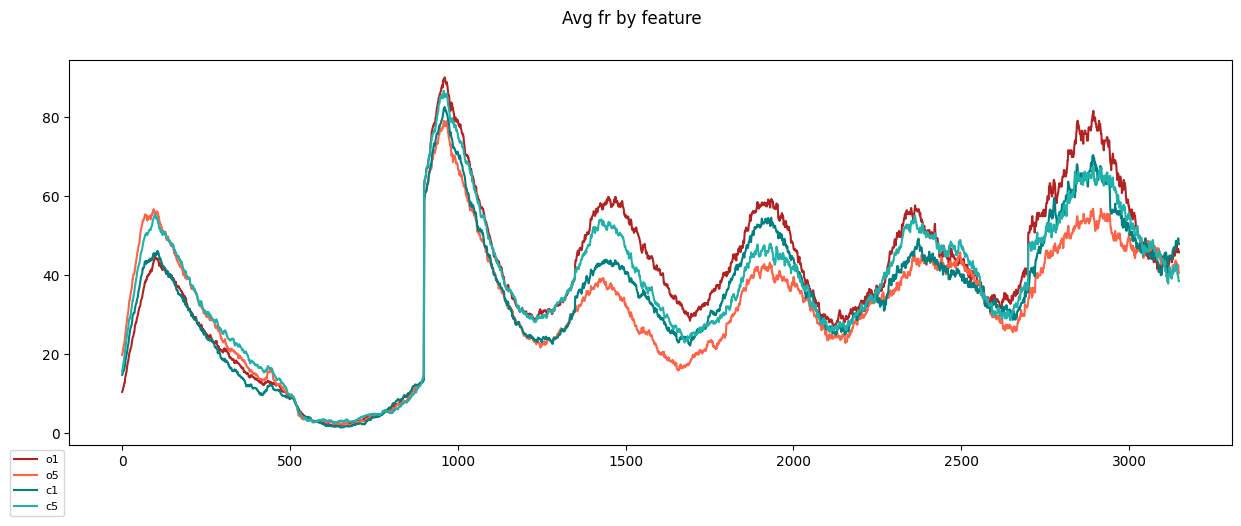

In [30]:
o1_avg_feature=[]
o5_avg_feature=[]
c1_avg_feature=[]
c5_avg_feature=[]
fig,ax = plt.subplots(figsize=(15,5))
for i,all_sp in enumerate(all_sp_epochs_feture):
    o1 = np.mean([all_sp[0],all_sp[1]],axis=0)
    o5 = np.mean([all_sp[2],all_sp[3]],axis=0)
    c1 = np.mean([all_sp[0],all_sp[2]],axis=0)
    c5 = np.mean([all_sp[1],all_sp[3]],axis=0)
    o1_avg_feature.append(moving_average(data=o1,win=win,step=1)[:450]*1000)
    o5_avg_feature.append(moving_average(data=o5,win=win,step=1)[:450]*1000)
    c1_avg_feature.append(moving_average(data=c1,win=win,step=1)[:450]*1000)
    c5_avg_feature.append(moving_average(data=c5,win=win,step=1)[:450]*1000)
o1_avg_feature=np.concatenate(o1_avg_feature)
o5_avg_feature=np.concatenate(o5_avg_feature)
c1_avg_feature=np.concatenate(c1_avg_feature)
c5_avg_feature=np.concatenate(c5_avg_feature)
ax.plot(o1_avg_feature,label='o1',color=task_constants.PALETTE_B1["o1_c1"])
ax.plot(o5_avg_feature,label='o5',color=task_constants.PALETTE_B1["o5_c1"])
ax.plot(c1_avg_feature,label='c1',color=task_constants.PALETTE_B1["o1_c5"])
ax.plot(c5_avg_feature,label='c5',color=task_constants.PALETTE_B1["o5_c5"])
fig.suptitle('Avg fr by feature')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Average trials by test number and feature

In [31]:
len_t1_on=450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_test1 = np.zeros((4,len_t1_on+win))

all_sample_feature_tests = {"o1_c1":{"color":{},"orientation":{}},"o1_c5":{"color":{},"orientation":{}},"o5_c1":{"color":{},"orientation":{}},"o5_c5":{"color":{},"orientation":{}}}
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    color_tests = []
    orient_tests = []
    task_sample = task[task['sample']==sample]
    trials = task_sample['trial_idx'].values
    test_stimuli_samp = test_stimuli[trials]
    code_numbers_samp = code_numbers[trials]
    code_samples_samp = code_samples[trials]
    sp_samples_samp = sp_samples[trials]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    
    for n_t in range(test_stimuli_samp.shape[1]):
        n_test = np.full(test_stimuli_samp.shape,np.nan)
        n_test[:,n_t] = test_stimuli_samp[:,n_t]
        color_tests=get_sp_feature(sp_samples_samp,n_test.astype(str),code_samples_samp,color_orient=color,stim_num=stim_num)
        orient_tests=get_sp_feature(sp_samples_samp,n_test.astype(str),code_samples_samp,color_orient=orient,stim_num=stim_num)
        all_sample_feature_tests[sample]["color"][str(n_t)]= color_tests
        all_sample_feature_tests[sample]["orientation"][str(n_t)]= orient_tests

/tmp/ipykernel_100963/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)
/tmp/ipykernel_100963/3330556799.py:22: RuntimeWarning: invalid value encountered in cast
  color_tests=get_sp_feature(sp_samples_samp,n_test.astype(str),code_samples_samp,color_orient=color,stim_num=stim_num)
/tmp/ipykernel_100963/3330556799.py:23: RuntimeWarning: invalid value encountered in cast
  orient_tests=get_sp_feature(sp_samples_samp,n_test.astype(str),code_samples_samp,color_orient=orient,stim_num=stim_num)


/tmp/ipykernel_100963/2425560791.py:6: RuntimeWarning: Mean of empty slice.
  tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].mean(axis=0)
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


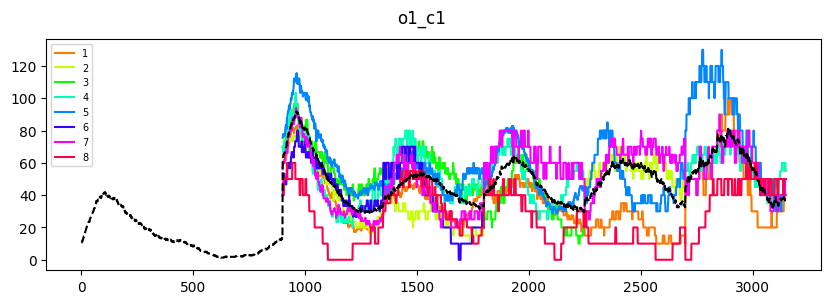

In [32]:
palette = plt.get_cmap('hsv',64)
o1_c1_orient = []
for i_test in range(5):
    o1_c1_orient_test = []
    for i in range(8):
        tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].mean(axis=0)
        tests = moving_average(data=tests,win=win,step=1)*1000
        o1_c1_orient_test.append(tests[:450])   
    o1_c1_orient.append(o1_c1_orient_test)

palette = plt.get_cmap('hsv',64)
all_o1_tests = np.concatenate([o1_c1_orient[0],o1_c1_orient[1],o1_c1_orient[2],o1_c1_orient[3],o1_c1_orient[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_o1_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(all_sp_epochs[0],'k--')
fig.suptitle('o1_c1')
plt.legend( prop={'size': 7})

Text(0.5, 0.98, 'o1_c1')

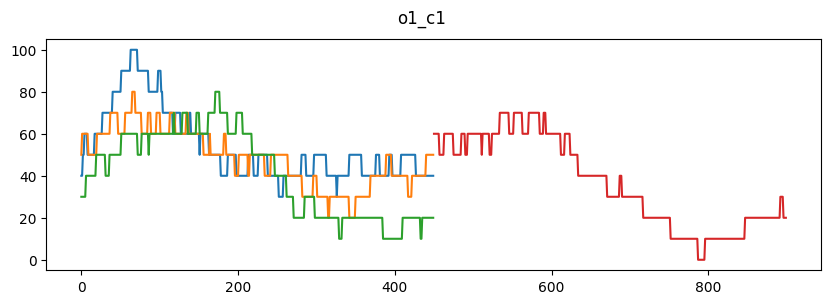

In [33]:
o1_c1_orient = []
for i_test in range(5):
    o1_c1_orient_test = []
    tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][5]
    for i_test in tests:
        i_test = moving_average(data=i_test,win=win,step=1)*1000
        o1_c1_orient_test.append(i_test[:450])   
    o1_c1_orient.append(o1_c1_orient_test)
palette = plt.get_cmap('hsv',64)
#all_o1_tests = np.concatenate([o1_c1_orient[0],o1_c1_orient[1],o1_c1_orient[2],o1_c1_orient[3],o1_c1_orient[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i_tr in o1_c1_orient[0]:
    ax.plot(i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[1]:
    ax.plot(np.arange(450,450*2),i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[2]:
    ax.plot(np.arange(450*2,450*3),i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[3]:
    ax.plot(np.arange(450*3,450*4),i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[4]:
    ax.plot(np.arange(450*4,450*5),i_tr,label=stim_num[i])
#ax.plot(all_sp_epochs[0],'k--')
fig.suptitle('o1_c1')


Text(0.5, 0.98, 'o1_c1')

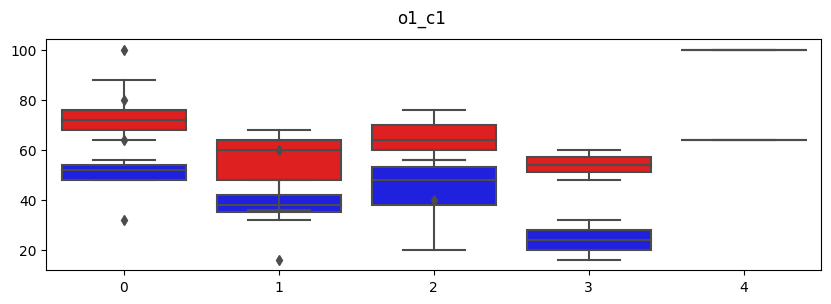

In [34]:
o1_c1_orient0 = []
o1_c1_orient5 = []
for i_test in range(5):
    tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][0]
    o1_c1_orient0.append(tests[:,100:350].mean(axis=1)*1000)   
    tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][4]
    o1_c1_orient5.append(tests[:,100:350].mean(axis=1)*1000)   

palette = plt.get_cmap('hsv',64)
#all_o1_tests = np.concatenate([o1_c1_orient[0],o1_c1_orient[1],o1_c1_orient[2],o1_c1_orient[3],o1_c1_orient[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
sns.boxplot(o1_c1_orient0,color='b')
sns.boxplot(o1_c1_orient5,color='r')
fig.suptitle('o1_c1')

In [35]:
o1_tests = []
o5_tests = []
c1_tests = []
c5_tests = []
for i_test in range(5):
    o1,o5,c1,c5 = [],[],[],[]
    for i in range(8):
        o1_avg = np.array([all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o1_c5"]['orientation'][str(i_test)][i].mean(axis=0)])
        o1_avg = np.mean(o1_avg,axis=0)
        o1_avg = moving_average(data=o1_avg,win=win,step=1)*1000
        o1.append(o1_avg[:450])
        # o5.append()
        o5_avg = np.array([all_sample_feature_tests["o5_c1"]['orientation'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['orientation'][str(i_test)][i].mean(axis=0)])
        o5_avg = np.mean(o5_avg,axis=0)
        o5_avg = moving_average(data=o5_avg,win=win,step=1)*1000
        o5.append(o5_avg[:450])
        # c1.append()
        c1_avg = np.array([all_sample_feature_tests["o1_c1"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c1"]['color'][str(i_test)][i].mean(axis=0)])
        c1_avg = np.mean(c1_avg,axis=0)
        c1_avg = moving_average(data=c1_avg,win=win,step=1)*1000
        c1.append(c1_avg[:450])
        # c5.append()
        c5_avg = np.array([all_sample_feature_tests["o1_c5"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['color'][str(i_test)][i].mean(axis=0)])
        c5_avg = np.mean(c5_avg,axis=0)
        c5_avg = moving_average(data=c5_avg,win=win,step=1)*1000
        c5.append(c5_avg[:450])
    o1_tests.append(o1)
    o5_tests.append(o5)
    c1_tests.append(c1)
    c5_tests.append(c5)

/tmp/ipykernel_100963/115818640.py:13: RuntimeWarning: Mean of empty slice.
  o5_avg = np.array([all_sample_feature_tests["o5_c1"]['orientation'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['orientation'][str(i_test)][i].mean(axis=0)])
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_100963/115818640.py:18: RuntimeWarning: Mean of empty slice.
  c1_avg = np.array([all_sample_feature_tests["o1_c1"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c1"]['color'][str(i_test)][i].mean(axis=0)])
/tmp/ipykernel_100963/115818640.py:23: RuntimeWarning: Mean of empty slice.
  c5_avg = np.array([all_sample_feature_tests["o1_c5"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['color'][str(i_test)][i].mean(axis=0)])
/tmp/ipykernel_100963/115818640.py:8: RuntimeWarning: Mean of empty slice.
 

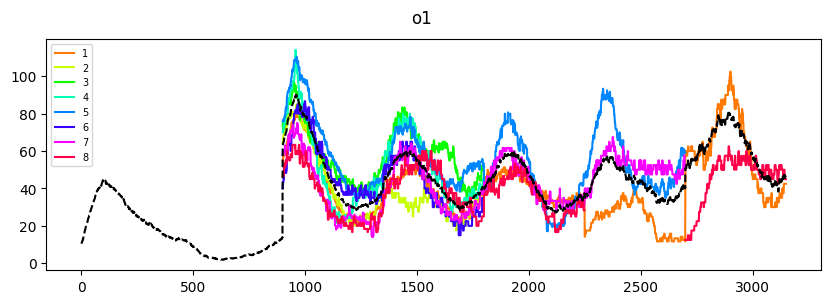

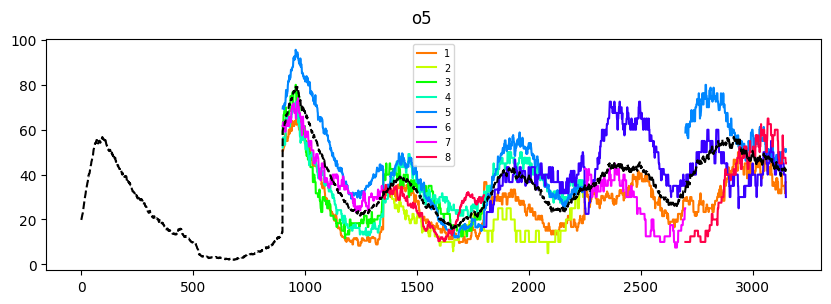

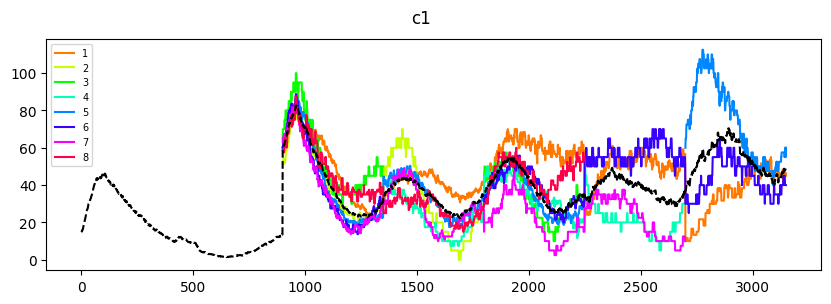

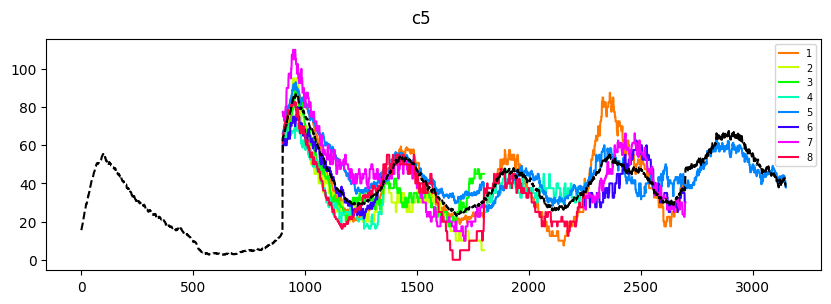

In [36]:
palette = plt.get_cmap('hsv',64)
all_o1_tests = np.concatenate([o1_tests[0],o1_tests[1],o1_tests[2],o1_tests[3],o1_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_o1_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(o1_avg_feature,'k--')
fig.suptitle('o1')
plt.legend( prop={'size': 7})

all_o5_tests = np.concatenate([o5_tests[0],o5_tests[1],o5_tests[2],o5_tests[3],o5_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_o5_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(o5_avg_feature,'k--')
fig.suptitle('o5')
plt.legend( prop={'size': 7})

all_c1_tests = np.concatenate([c1_tests[0],c1_tests[1],c1_tests[2],c1_tests[3],c1_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_c1_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(c1_avg_feature,'k--')
fig.suptitle('c1')
plt.legend( prop={'size': 7})

all_c5_tests = np.concatenate([c5_tests[0],c5_tests[1],c5_tests[2],c5_tests[3],c5_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_c5_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(c5_avg_feature,'k--')
fig.suptitle('c5')
plt.legend( prop={'size': 7})

### Average trials by test feature

In [37]:
len_t1_on=450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_test1 = np.zeros((4,len_t1_on+win))

all_sample_feature = {"o1_c1":{"color":[],"orientation":[]},"o1_c5":{"color":[],"orientation":[]},"o5_c1":{"color":[],"orientation":[]},"o5_c5":{"color":[],"orientation":[]}}
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):

    
    task_sample = task[task['sample']==sample]
    trials = task_sample['trial_idx'].values
    test_stimuli_samp = test_stimuli[trials]
    code_numbers_samp = code_numbers[trials]
    code_samples_samp = code_samples[trials]
    sp_samples_samp = sp_samples[trials]
    
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    # use only the first 2 test stimuli presentations
    n_test = np.full(test_stimuli_samp.shape,np.nan)
    n_test[:,:6] = test_stimuli_samp[:,:6]
    n_test=n_test.astype(str)
    
    color_tests = get_sp_feature(sp_samples_samp,n_test,code_samples_samp,color_orient=color,stim_num=stim_num)
    orient_tests = get_sp_feature(sp_samples_samp,n_test,code_samples_samp,color_orient=orient,stim_num=stim_num)

    all_sample_feature[sample]["color"]= color_tests
    all_sample_feature[sample]["orientation"]= orient_tests

/tmp/ipykernel_100963/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)
/tmp/ipykernel_100963/467431450.py:22: RuntimeWarning: invalid value encountered in cast
  n_test=n_test.astype(str)


In [38]:
o1_mean_sample = []
o5_mean_sample = []
c1_mean_sample = []
c5_mean_sample = []
for i in range(8):
    o1_mean_sample.append(np.array([all_sample_feature["o1_c1"]['orientation'][i].mean(axis=0),all_sample_feature["o1_c5"]['orientation'][i].mean(axis=0)]))
    # print("o1 - o%d n trials: %d"%(i,o1[i].shape[0]))
    o5_mean_sample.append(np.array([all_sample_feature["o5_c1"]['orientation'][i].mean(axis=0),all_sample_feature["o5_c5"]['orientation'][i].mean(axis=0)]))
    # print("o5 - o%d n trials: %d"%(i,o5[i].shape[0]))
    c1_mean_sample.append(np.array([all_sample_feature["o1_c1"]['color'][i].mean(axis=0),all_sample_feature["o5_c1"]['color'][i].mean(axis=0)]))
    # print("c1 - c%d n trials: %d"%(i,c1[i].shape[0]))
    c5_mean_sample.append(np.array([all_sample_feature["o1_c5"]['color'][i].mean(axis=0),all_sample_feature["o5_c5"]['color'][i].mean(axis=0)]))
    # print("c5 - c%d n trials: %d"%(i,c5[i].shape[0]))

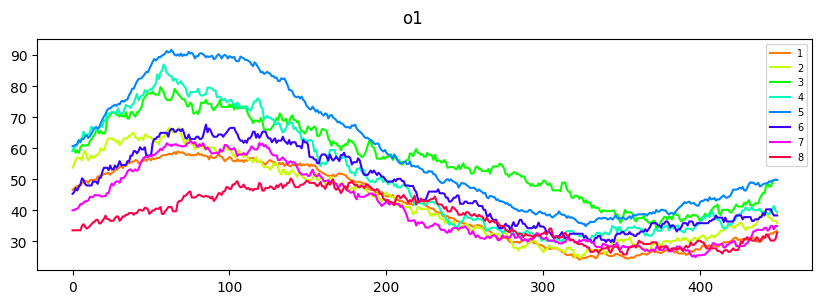

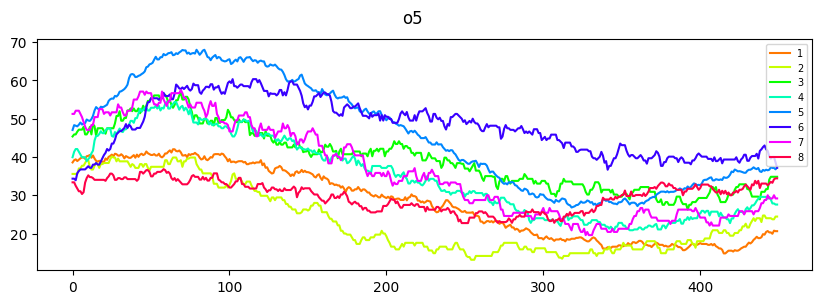

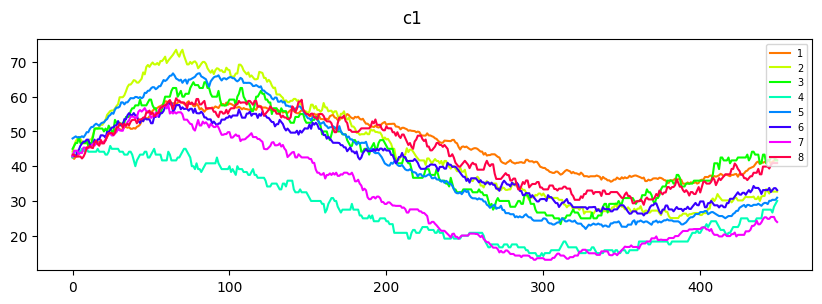

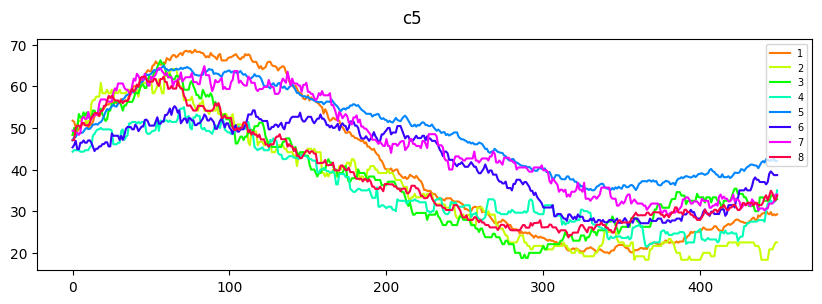

In [39]:
palette = plt.get_cmap('hsv',64)

fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(o1_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('o1')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(o5_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('o5')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(c1_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('c1')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(c5_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('c5')
    plt.legend( prop={'size': 7})

### Avg activity by test feature

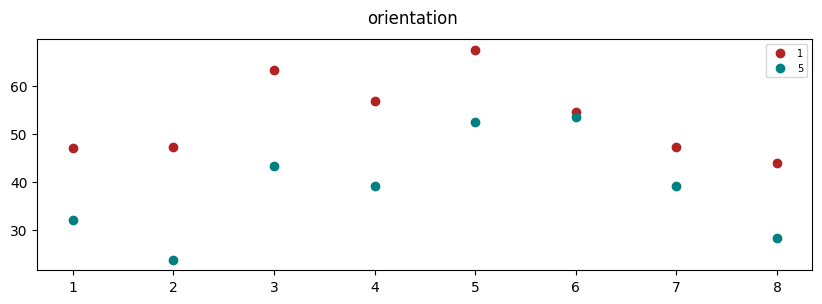

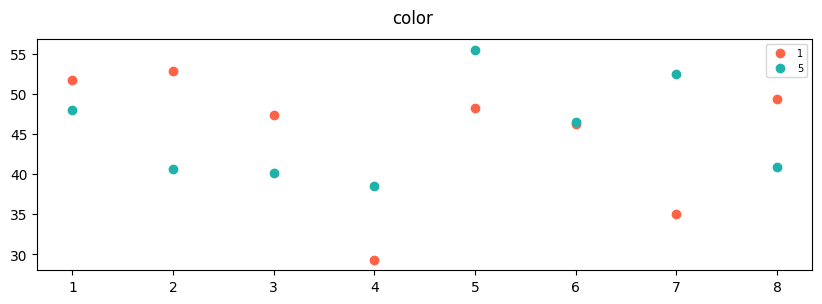

In [40]:
sample=["o1_c1","o5_c1","o1_c5","o5_c5"]
fig,ax = plt.subplots(figsize=(10,3))
o1_i_all=[]
o5_i_all=[]
for i, (o1_i,o5_i) in enumerate(zip(o1_mean_sample,o5_mean_sample)):
    o1_i_all.append(o1_i[:,100:350].mean()*1000)
    o5_i_all.append(o5_i[:,100:350].mean()*1000)
    
ax.scatter(range(1,9),o1_i_all,color=task_constants.PALETTE_B1[sample[0]],label='1')
ax.scatter(range(1,9),o5_i_all,color=task_constants.PALETTE_B1[sample[2]],label='5')
fig.suptitle('orientation')
ax.legend( prop={'size': 7})

fig,ax = plt.subplots(figsize=(10,3))
c1_i_all=[]
c5_i_all=[]
for i, (c1_i,c5_i) in enumerate(zip(c1_mean_sample,c5_mean_sample)):
    c1_i_all.append(c1_i[:,100:350].mean()*1000)
    c5_i_all.append(c5_i[:,100:350].mean()*1000)
    
ax.scatter(range(1,9),c1_i_all,color=task_constants.PALETTE_B1[sample[1]],label='1')
ax.scatter(range(1,9),c5_i_all,color=task_constants.PALETTE_B1[sample[3]],label='5')
fig.suptitle('color')
ax.legend( prop={'size': 7})

## Check if selective to color or orientation

In [126]:
o1_all = []
o5_all = []
c1_all = []
c5_all = []
for i in range(8):
    o1_all.append(np.concatenate([all_sample_feature["o1_c1"]['orientation'][i],all_sample_feature["o1_c5"]['orientation'][i]],axis=0))
    print("o1 - o%d n trials: %d"%(i,o1_all[i].shape[0]))
    o5_all.append(np.concatenate([all_sample_feature["o5_c1"]['orientation'][i],all_sample_feature["o5_c5"]['orientation'][i]],axis=0))
    print("o5 - o%d n trials: %d"%(i,o5_all[i].shape[0]))
    c1_all.append(np.concatenate([all_sample_feature["o1_c1"]['color'][i],all_sample_feature["o5_c1"]['color'][i]],axis=0))
    print("c1 - c%d n trials: %d"%(i,c1_all[i].shape[0]))
    c5_all.append(np.concatenate([all_sample_feature["o1_c5"]['color'][i],all_sample_feature["o5_c5"]['color'][i]],axis=0))
    print("c5 - c%d n trials: %d"%(i,c5_all[i].shape[0]))

o1 - o0 n trials: 41
o5 - o0 n trials: 25
c1 - c0 n trials: 40
c5 - c0 n trials: 35
o1 - o1 n trials: 11
o5 - o1 n trials: 11
c1 - c1 n trials: 13
c5 - c1 n trials: 7
o1 - o2 n trials: 13
o5 - o2 n trials: 9
c1 - c2 n trials: 6
c5 - c2 n trials: 9
o1 - o3 n trials: 11
o5 - o3 n trials: 16
c1 - c3 n trials: 10
c5 - c3 n trials: 13
o1 - o4 n trials: 32
o5 - o4 n trials: 44
c1 - c4 n trials: 27
c5 - c4 n trials: 46
o1 - o5 n trials: 8
o5 - o5 n trials: 11
c1 - c5 n trials: 13
c5 - c5 n trials: 10
o1 - o6 n trials: 15
o5 - o6 n trials: 6
c1 - c6 n trials: 17
c5 - c6 n trials: 6
o1 - o7 n trials: 11
o5 - o7 n trials: 13
c1 - c7 n trials: 12
c5 - c7 n trials: 13


In [42]:
# !tengo que usar todos los trials, aca tengo el avg de dos samples !!!!!!!!!!!!!!
o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg=[],[],[],[]
n_trials=[]
for i in range(8):
    n_tr=[]
    avg = o1_all[i][:,50:350].mean(axis=1)*1000
    o1_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = o5_all[i][:,50:350].mean(axis=1)*1000
    o5_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = c1_all[i][:,50:350].mean(axis=1)*1000
    c1_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = c5_all[i][:,50:350].mean(axis=1)*1000
    c5_trial_avg.append(avg)
    n_tr.append(len(avg))
    n_trials.append(n_tr)

In [43]:
n_trials

[[49, 36, 49, 39],
 [13, 12, 16, 8],
 [14, 11, 9, 10],
 [14, 17, 12, 16],
 [38, 51, 34, 57],
 [11, 17, 17, 14],
 [19, 10, 20, 13],
 [15, 18, 14, 17]]

#### Def funct

In [44]:
def select_rand_trials_from_samples(trials_fr,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]
    for n_it in range(n_iterations):
        np.random.seed(it_seed[n_it]) 
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr = np.random.choice(trials_fr[i_num], size=min_n_trials[i_num], replace=True, p=None)
            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [45]:
def get_null_vector_from_samples(trials_fr,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]

    for n_it in range(n_iterations):
        all_sample1 = []
        
        np.random.seed(it_seed[n_it]) 
        for i_num,i_stim in enumerate(stim_num):
            all_sample1.append(np.random.choice(trials_fr[i_num], size=min_n_trials[i_num], replace=False, p=None))
        all_sample1 = np.concatenate(all_sample1)
       
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr = np.random.choice(all_sample1, size=min_n_trials[i_num], replace=True, p=None)

            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [46]:
## Permutation test
def permutation_test(mean_select,mean_null):
    radius = mean_select[:,0]
    angle =  mean_select[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_dir_vector = np.sqrt(X**2+Y**2)
    radius = mean_null[:,0]
    angle =  mean_null[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_null_vector = np.sqrt(X**2+Y**2)
    diff=[]
    for i in range(len(ampl_dir_vector)):
        shift = np.concatenate([ampl_dir_vector[i:],ampl_dir_vector[:i]])
        diff.append(shift-ampl_null_vector)
    diff=np.concatenate(diff)
    p_value = np.sum(diff<0)/len(diff)
    return p_value

### Plot

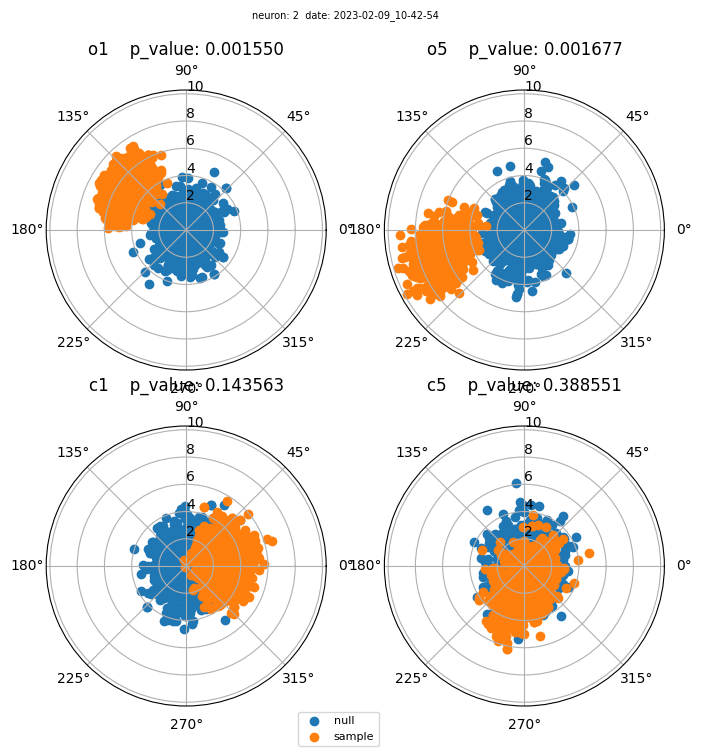

In [47]:
selectivity_info: Dict[str, list] = defaultdict(list)

min_n_trials = np.min(n_trials,axis=1).astype(int)
all_select = []
all_null=[]
all_p_value=[]
for trial_avg,feature in zip([o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg],['o1','o5','c1','c5']):

    if np.sum(min_n_trials<3)>0:
        p_value = np.nan
        mean_null = np.zeros((2,2))
        mean_select = np.zeros((2,2))
    else:
        mean_select = select_rand_trials_from_samples(trial_avg,min_n_trials,seed,n_iterations=1000)
        mean_null = get_null_vector_from_samples(trial_avg,min_n_trials,seed,n_iterations=1000)
        p_value = permutation_test(mean_select,mean_null)

    all_select.append(mean_select)
    all_null.append(mean_null)
    all_p_value.append(p_value)
    selectivity_info['date'] += [date]
    selectivity_info['i_neuron'] += [i_neuron]
    selectivity_info['neuron_type'] += [data.clustersgroup[i_neuron]]
    selectivity_info['p_value'] += [p_value]
    selectivity_info['sample1'] += [feature]


selectivity_info = pd.DataFrame(selectivity_info) 

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
for i,(ax, feature)in enumerate(zip([ax1,ax2,ax3,ax4],['o1','o5','c1','c5'])):
    ax.set_rlabel_position(90)
    ax.scatter(all_null[i][:,1],all_null[i][:,0],label='null')
    ax.scatter(all_select[i][:,1],all_select[i][:,0],label='sample')
    ax.set_title('%s    p_value: %f'%(feature,all_p_value[i]) )
fig.suptitle('neuron: %d  date: %s'%(i_neuron,date),fontsize=7)

plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_100963/3659575917.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['o1','o2','o3','o4','o5','o6','o7','o8'])
/tmp/ipykernel_100963/3659575917.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['c1','c2','c3','c4','c5','c6','c7','c8'])


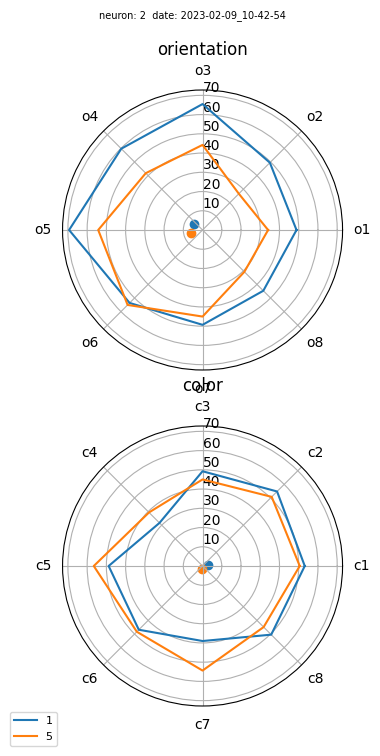

In [48]:
stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
min_n_trials = np.min(n_trials,axis=1).astype(int)
dir_vector = []
all_mean_resp=[]
for trial_avg,feature in zip([o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg],['o1','o5','c1','c5']):
    if np.sum(min_n_trials<3)>0:
        p_value = np.nan
        mean_null = np.zeros((2,2))
        mean_select = np.zeros((2,2))
        mean_resp = np.zeros((8,3))
    else:
        mean_select=[]
        mean_resp = np.zeros((8,3))
        for i_num in range(8):
            fr = trial_avg[i_num]
            mean_resp[i_num] = [np.mean(fr),np.std(fr),stim_angle[i_num]]
    dir_vector.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,2]))
    all_mean_resp.append(mean_resp)
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),sharey=True,subplot_kw={'projection': 'polar'})
for i,(ax, feature)in enumerate(zip([ax1,ax1,ax2,ax2],['o1','o5','c1','c5'])):
    ax.set_rlabel_position(90)
    mean_angle = np.concatenate([all_mean_resp[i][:,2],[all_mean_resp[i][0,2]]])
    mean_fr = np.concatenate([all_mean_resp[i][:,0],[all_mean_resp[i][0,0]]])
    ax.plot(mean_angle, mean_fr ,label=['1','5','1','5'][i])
    ax.scatter(dir_vector[i][1],dir_vector[i][0])
    title = 'color'
    
    if feature in ['o1','o5']:
        title = 'orientation'

    #ax.plot(all_mean_resp[i][:,2],all_mean_resp[i][:,0]+all_mean_resp[i][:,1],label='std')
    ax.set_title(title)
ax1.set_xticklabels(['o1','o2','o3','o4','o5','o6','o7','o8'])
ax2.set_xticklabels(['c1','c2','c3','c4','c5','c6','c7','c8'])    
fig.suptitle('neuron: %d  date: %s'%(i_neuron,date),fontsize=7)
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Testing